In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

original_df = pd.read_csv('../data/all_financial_with_keywords.csv')

# Target Variable

Our target variable will be the **diff** column. That represents the differnece in price, (close - open), on the day the IPO was released.

## Target Varialbe Cleaning

Target variable seems to have floats for each row and no missing data.

In [37]:
original_df['diff'].describe()

count    2025.000000
mean        0.044669
std         3.240810
min       -35.270000
25%        -0.310000
50%         0.000000
75%         0.150000
max        68.140000
Name: diff, dtype: float64

## Target Variable Distribution

Almost normal distribution, with huge tails. To be expected given the nature of financial data.

<Axes: xlabel='diff', ylabel='Count'>

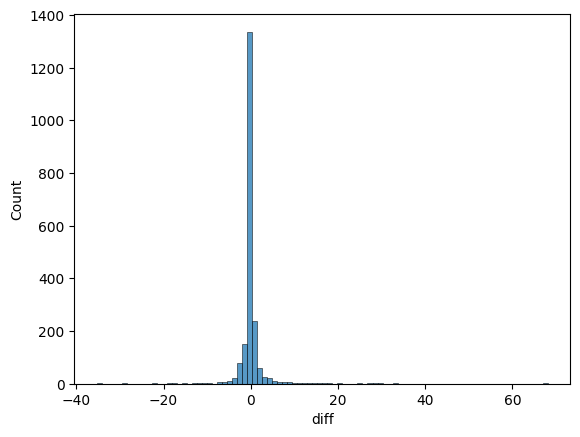

In [4]:
sns.histplot(original_df['diff'])

## Target Variable Scale

Putting the target variable into the terms of percent change will reduce the scale of the deltas. This should help the model understand the deltas better, as a stock can move 10 or 100 points, but that is relative to it's price magnitude.

<Axes: xlabel='diff_percent', ylabel='Count'>

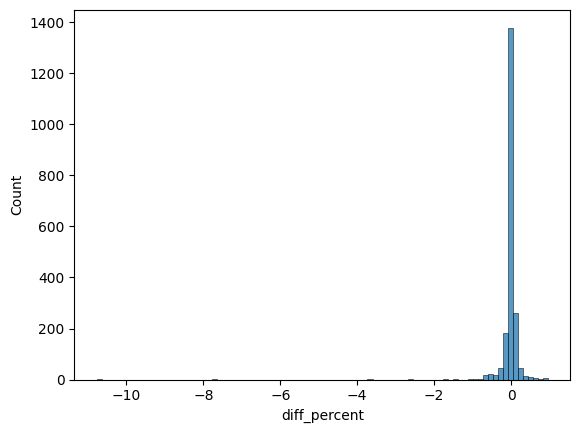

In [9]:
original_df['open'] = original_df['diff'] + original_df['close']
original_df['diff_percent'] = original_df['diff'] / original_df['close']
sns.histplot(data=original_df['diff_percent'])

## Target Variable Outliers

1. There are a few values that are over a 100% change in price, and they are negative.
2. Outliers are under -0.15 and over 0.13 percent.
3. Heavily skewed left
4. Roughly 15% of the data contains outliers. The large Kurtosis value indicates very large tails.
5. Will discard the crazy negative outliers and retain the rest. Financial data may have large tails.

In [14]:
def identify_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 2.0 * IQR
    upper_bound = Q3 + 2.0 * IQR
    
    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print(original_df['diff_percent'].describe())

kurt = original_df['diff_percent'].kurtosis()
skew = original_df['diff_percent'].skew()

print(f'Skew: {skew}, Kurt: {kurt}')

count    2025.000000
mean       -0.029981
std         0.351082
min       -10.766667
25%        -0.036765
50%         0.000000
75%         0.019608
max         0.956989
Name: diff_percent, dtype: float64
Skew: -20.24064300267408, Kurt: 552.0146526153917


In [20]:
outliers, lowerbound, upperbound = identify_outliers_iqr(original_df, 'diff_percent')
print(lowerbound,upperbound)
print(outliers['diff_percent'].describe())

-0.14950980392156862 0.1323529411764706
count    301.000000
mean      -0.179593
std        0.889429
min      -10.766667
25%       -0.333333
50%       -0.179941
75%        0.190751
max        0.956989
Name: diff_percent, dtype: float64


In [24]:
# Remove the over 100% change values
outlier_free_df = original_df[(original_df['diff_percent'] > -1.0) & (original_df['diff_percent'] < 1.0)]
skew = outlier_free_df['diff_percent'].skew()
kurt = outlier_free_df['diff_percent'].kurt()
outliers, lowerbound, upperbound = identify_outliers_iqr(outlier_free_df, 'diff_percent')

print(outliers['diff_percent'].describe())
print(f'Skew {skew}, Kurt {kurt}')
print(outlier_free_df['diff_percent'].describe())

count    300.000000
mean      -0.079373
std        0.373818
min       -0.994681
25%       -0.306458
50%       -0.167858
75%        0.191571
max        0.956989
Name: diff_percent, dtype: float64
Skew -0.7716034106531567, Kurt 11.787561322797334
count    2017.000000
mean       -0.015145
std         0.153233
min        -0.994681
25%        -0.035836
50%         0.000000
75%         0.019749
max         0.956989
Name: diff_percent, dtype: float64


## Target Variable Conclusions

1. Morphing the 'diff' column into a percentage based value proves to be closer to normal distribution.
2. Removing the major outliers, above 100% change, put's the skew into a moderate range of -0.77
3. After removing the major outliers, roughly 300 rows still fall into the outlier range. This puts our Kurtosis score at 11.78, indication some huge tails. The nature of the financial data will likely benefit from keeping those for the final model however.

<Axes: xlabel='diff_percent', ylabel='Count'>

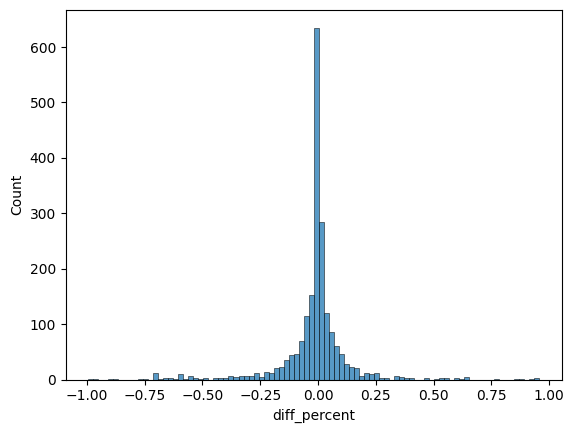

In [25]:
sns.histplot(outlier_free_df['diff_percent'])

## Target Variable Algorithmn

In [30]:
def prep_target_variable(original_df, column='diff'):
    # Convert to percent based deltas
    original_df['open'] = original_df[column] + original_df['close']
    original_df['diff_percent'] = original_df[column] / original_df['close']
    
   # Remove the over 100% change values
    final_df = original_df[(original_df['diff_percent'] > -1.0) & (original_df['diff_percent'] < 1.0)]
    